In [1]:
# saving all pixels values in one matrix (tip: use memory map because matrices now are gonna be huge)
# matrix size for one frame = (17640,1) 
# matrix size for 2700 frames = (17640, 2700)

#Let's load one frame and save pixels

import numpy as np
import matplotlib.pyplot as plt
import imageio
import imageio.v3 as iio
import skimage as ski
import cv2
import os
from scipy.optimize import curve_fit

from scipy.ndimage import label, center_of_mass
from ipynb.fs.full.phase_unwrap import phase_unwrap, _wrapToPi
import matplotlib.colors as mcolors
import glob
def rms(data):
    return np.sqrt(np.mean(np.square(data)))

In [2]:
import pandas as pd

In [5]:
%cd D:\Europhotonics Masters\MATLAB\LAM\21March\testt\2700 frames analysis\ff_frames_npy format

D:\Europhotonics Masters\MATLAB\LAM\21March\testt\2700 frames analysis\ff_frames_npy format


In [94]:
pixels = 176400
num_frames = 1000  #range(frames)

# defining the matrix (as i gonna append there is no definition for the shape)
mat = np.empty((pixels,1))

# let's do it all in the memory map
filename = os.path.abspath("test04.dat")
data = np.memmap(filename, dtype=np.float32, mode='w+', shape=(pixels, num_frames))
#main loop over the wavefront frames
for j in range(num_frames):
    f = np.load(f"frame_{j:04d}.npy", allow_pickle=True)
    data[:,j] = f.flatten()

In [92]:
def averaged_std(pixel_data):
    # input pixel_data is supposed to be an array
    stdd = [np.std(pixel_data)]
    N = len(pixel_data)
    data = np.copy(pixel_data)
    new_data = []
    while N>=10:
        for i in range(N//2):
            a = np.mean([data[i], data[N-(i+1)]])
            new_data.append(a)
        stdd.append(np.std(new_data))
        N = len(new_data)
        data = np.copy(new_data)
        new_data.clear()
    return stdd

In [95]:
results = np.apply_along_axis(averaged_std, axis=1, arr=data)

In [97]:
print(results.shape)

(176400, 8)


In [98]:
wavefront_pixel_average_stdd = np.mean(results, axis = 0)

[0.07715649 0.0563343  0.03963443 0.02214134 0.01372682 0.00893717
 0.0046156  0.00222317]


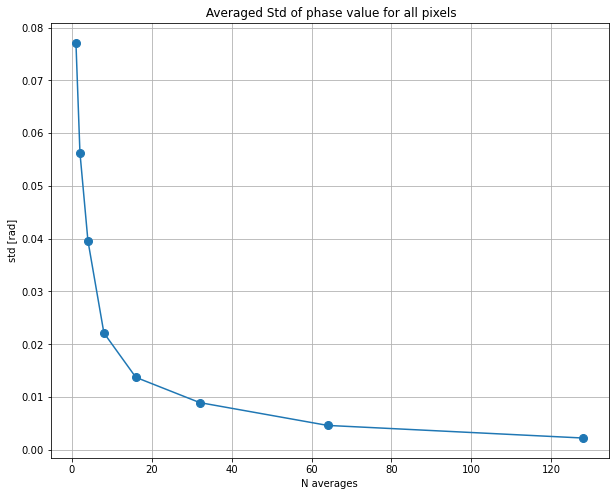

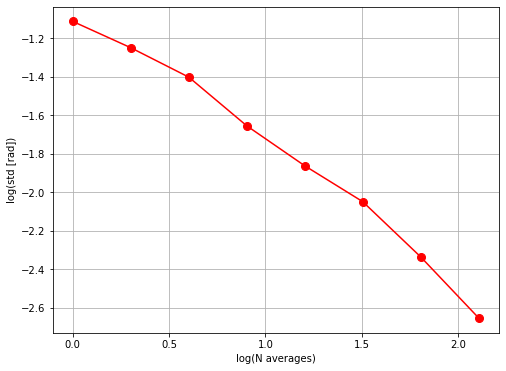

In [101]:
print(wavefront_pixel_average_stdd)
stdd1 = wavefront_pixel_average_stdd
length = len(wavefront_pixel_average_stdd)
plt.figure(figsize=(10,8))
x1 = np.linspace(0,length-1,length)
x_axis1 = 2**x1
plt.plot(x_axis1, stdd1,marker='o', markersize=8)
plt.grid()
plt.title(' Averaged Std of phase value for all pixels')
plt.xlabel('N averages')
plt.ylabel('std [rad]')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(np.log10(x_axis1), np.log10(stdd1),marker='o', color='red', markersize=8)
# plt.ylim(-2.0,0.0)
plt.grid('True')
plt.ylabel('log(std [rad])')
plt.xlabel('log(N averages)')
plt.show()

Standard deviation (in nm):  [7.7608566  5.666437   3.986666   2.227107   1.3807245  0.8989534
 0.46426412 0.22361936]


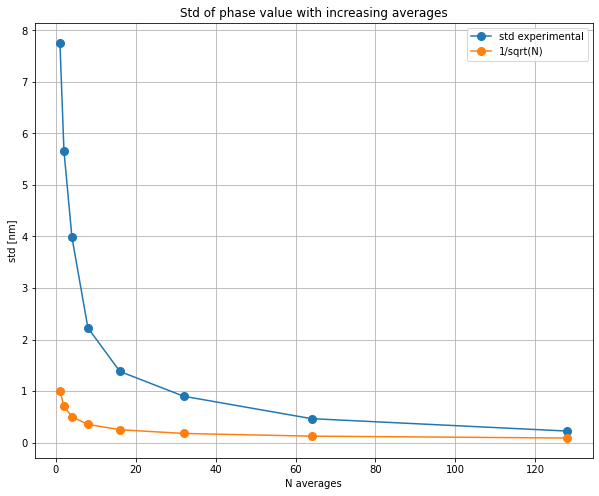

In [104]:
# std until now is in rad where phi = (2*pi/lambda)*path_difference
wavelength = 632 # in nm
std_opd = np.array(stdd1)* (wavelength/(2*np.pi))  # in nm
print('Standard deviation (in nm): ',std_opd)
plt.figure(figsize=(10,8))
x1 = np.linspace(0,len(std_opd)-1,len(std_opd))
x_axis1 = 2**x1
plt.plot(x_axis1, std_opd,marker='o', markersize=8, label='std experimental')
plt.plot(x_axis1, 1/np.sqrt(x_axis1),marker='o', markersize=8, label='1/sqrt(N)')
plt.grid()
plt.title('Std of phase value with increasing averages')
plt.xlabel('N averages')
plt.ylabel('std [nm]')
plt.legend()
plt.show()

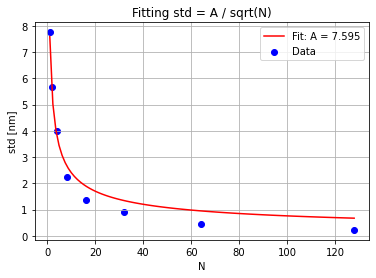

For std = 0.1nm, corresponding N = 5768
For std = 0.01nm, corresponding N = 576809
For std = 0.001nm, corresponding N = 57680948


In [103]:
N = x_axis1;
y = std_opd

# Define the model function y = A / sqrt(N)
def model(N, A):
    return A / np.sqrt(N)

# Perform curve fitting
A_opt, _ = curve_fit(model, N, y, p0=[1])  # Initial guess A=1
A_fit = A_opt[0]
# Generate fitted curve
N_fit = np.linspace(min(N), max(N), 100)  # Smooth range for plotting
y_fit = model(N_fit, A_fit)

# Plot results
plt.scatter(N, y, color='blue', label='Data')  # Original data points
plt.plot(N_fit, y_fit, 'r-', label=f'Fit: A = {A_fit:.3f}')  # Fitted curve
plt.xlabel('N')
plt.ylabel('std [nm]')
plt.legend()
plt.grid()
plt.title('Fitting std = A / sqrt(N)')
plt.show()

# from this fit now let's try to find the the values of N for which I could reach 1nm, 100pm, 10pm, 1pm ?
y_target = [0.1, 0.01, 0.001]   # Target std values
N_target = (A_fit/y_target)**2   # Compute corresponding N
print(f'For std = {y_target[0]}nm, corresponding N = {round(N_target[0])}')
print(f'For std = {y_target[1]}nm, corresponding N = {round(N_target[1])}')
print(f'For std = {y_target[2]}nm, corresponding N = {round(N_target[2])}')